In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clustering/Dataset/Audio_Features.pdf
/kaggle/input/clustering/Dataset/train_labels.csv
/kaggle/input/clustering/Dataset/train_folder/611.wav
/kaggle/input/clustering/Dataset/train_folder/364.wav
/kaggle/input/clustering/Dataset/train_folder/367.wav
/kaggle/input/clustering/Dataset/train_folder/116.wav
/kaggle/input/clustering/Dataset/train_folder/1490.wav
/kaggle/input/clustering/Dataset/train_folder/374.wav
/kaggle/input/clustering/Dataset/train_folder/1359.wav
/kaggle/input/clustering/Dataset/train_folder/485.wav
/kaggle/input/clustering/Dataset/train_folder/456.wav
/kaggle/input/clustering/Dataset/train_folder/626.wav
/kaggle/input/clustering/Dataset/train_folder/590.wav
/kaggle/input/clustering/Dataset/train_folder/296.wav
/kaggle/input/clustering/Dataset/train_folder/1180.wav
/kaggle/input/clustering/Dataset/train_folder/1312.wav
/kaggle/input/clustering/Dataset/train_folder/66.wav
/kaggle/input/clustering/Dataset/train_folder/468.wav
/kaggle/input/clustering/Datase

In [2]:
!pip install librosa --quiet


Install and Import Libraries


In [3]:
# File and audio handling
import os
import librosa

# Numerical and data manipulation
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.preprocessing import StandardScaler

# For tracking progress
from tqdm import tqdm

# For clustering and evaluation (for later stages)
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import random
from sklearn.preprocessing import LabelEncoder

1. Dataset Split (without shuffling)



In [4]:
import os

# List all audio file paths
data_dir = '/kaggle/input/clustering/Dataset/train_folder'  # update this based on actual dataset path
audio_files = sorted(os.listdir(data_dir))  # ensure order is maintained

# Split
total = len(audio_files)
train_split = int(0.6 * total)
val_split = int(0.8 * total)

train_files = audio_files[:train_split]
val_files = audio_files[train_split:val_split]
test_files = audio_files[val_split:]


2. Feature Extraction

 Define the Feature Extraction Function

In [5]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_var = np.var(mfcc, axis=1)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    # Time-domain features
    zcr = librosa.feature.zero_crossing_rate(y=y).mean().item()
    energy = np.mean(y ** 2).item()

    # Spectral features
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean().item()
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean().item()

    # Rhythmic features
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    tempo = float(tempo) if np.isscalar(tempo) else tempo.item()
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onset_mean = onset_env.mean().item()

    # Combine features
    features = np.concatenate([
        mfcc_mean.flatten(),
        mfcc_var.flatten(),
        np.mean(mfcc_delta, axis=1).flatten(),
        np.mean(mfcc_delta2, axis=1).flatten(),
        np.array([
            zcr, energy, spec_centroid, spec_bandwidth, tempo, onset_mean
        ])
    ])

    return features


Extract Features for All Files

In [6]:
features_list = []
index_list = []

for fname in tqdm(train_files):
    path = os.path.join(data_dir, fname)
    feats = extract_features(path)
    features_list.append(feats)
    index_list.append(fname)

features_df = pd.DataFrame(features_list)
features_df['filename'] = index_list
features_df.set_index('filename', inplace=True)


100%|██████████| 900/900 [03:26<00:00,  4.36it/s]


 Normalize the Features

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

features_df[:] = scaled_features  # normalize in place


Save to CSV

In [8]:
features_df.to_csv("audio_features.csv")

.

3. Exploratory Data Analysis (EDA)

Load Feature CSV and Labels

In [9]:
# Load extracted features
pd.read_csv("/kaggle/working/audio_features.csv", index_col=0)


# Load true labels
labels_df = pd.read_csv('/kaggle/input/clustering/Dataset/train_labels.csv')  # Assuming it has 'filename' and 'label' columns

# Merge for plotting
df = features_df.merge(labels_df, left_index=True, right_on='filename')


 Visualize Audio Waveform and Spectrogram

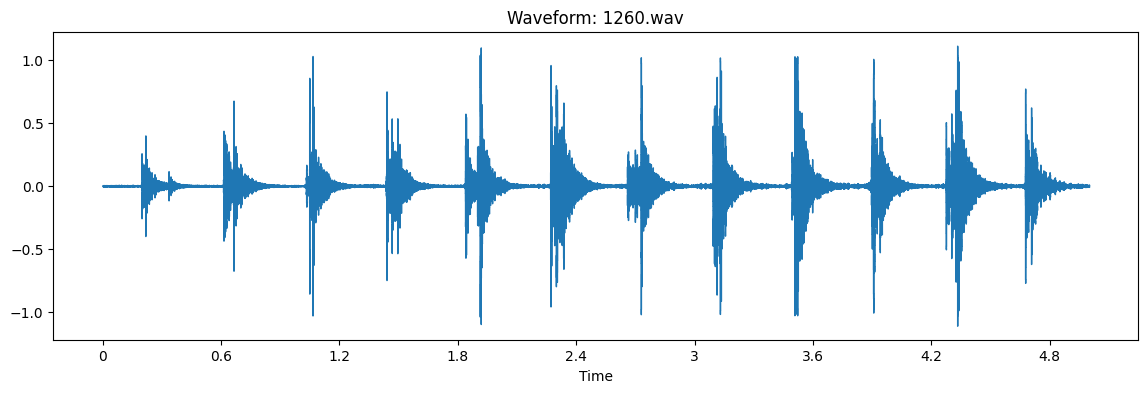

In [10]:
sample_file = df['filename'].iloc[random.randint(0, len(df))]  # pick random file
y, sr = librosa.load(os.path.join(data_dir, sample_file))

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform: {sample_file}")
plt.show()

Spectrogram:

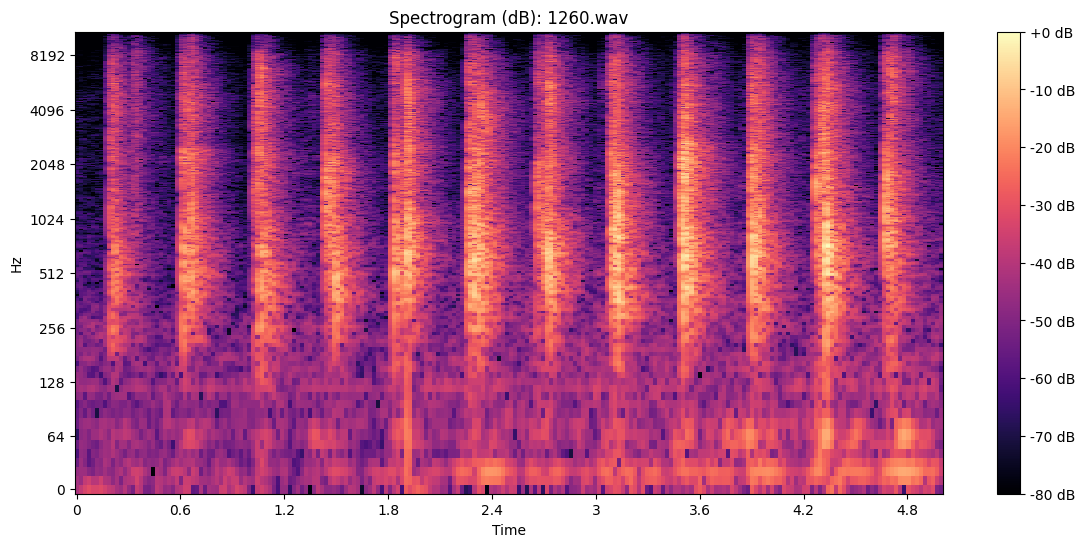

In [11]:
plt.figure(figsize=(14, 6))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title(f"Spectrogram (dB): {sample_file}")
plt.colorbar(format="%+2.0f dB")
plt.show()


Plot MFCCs and Zero-Crossing Rate

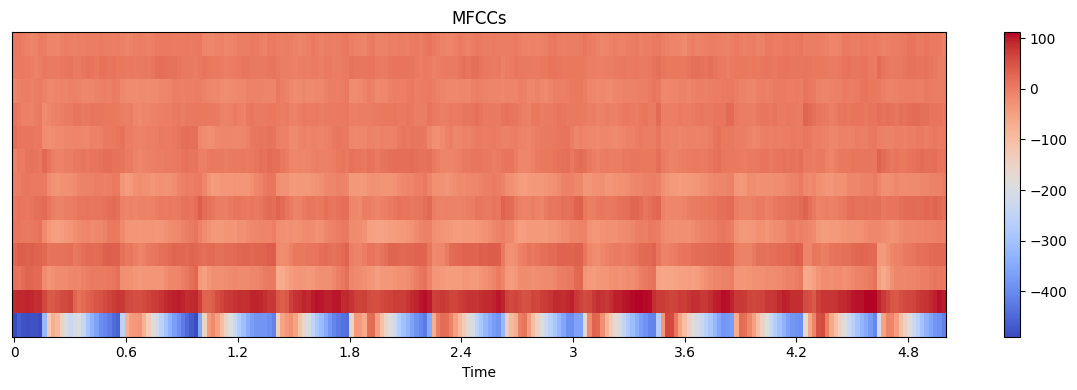

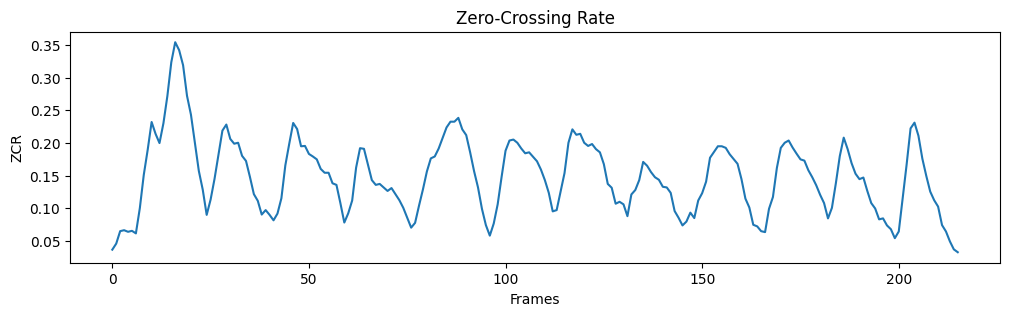

In [12]:
# MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.tight_layout()
plt.show()

# Zero Crossing Rate
zcr = librosa.feature.zero_crossing_rate(y)
plt.figure(figsize=(12, 3))
plt.plot(zcr[0])
plt.title('Zero-Crossing Rate')
plt.xlabel('Frames')
plt.ylabel('ZCR')
plt.show()


Explore Correlation Between Features and Labels

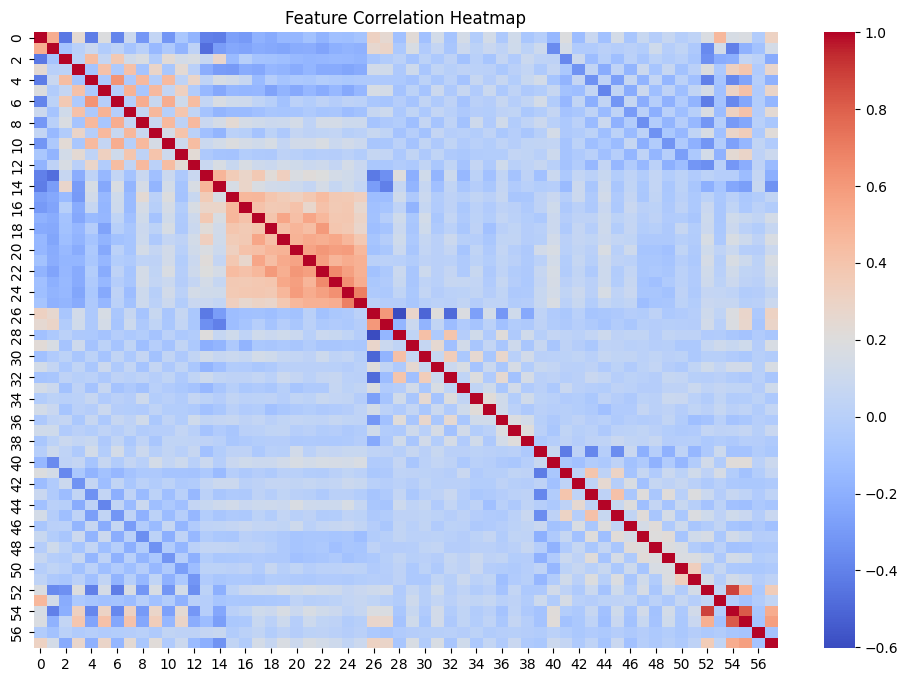

In [13]:
# Correlation Heatmap
correlation_matrix = df.drop(columns=["filename"]).select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

Analyze feature distributions using appropriate plots.

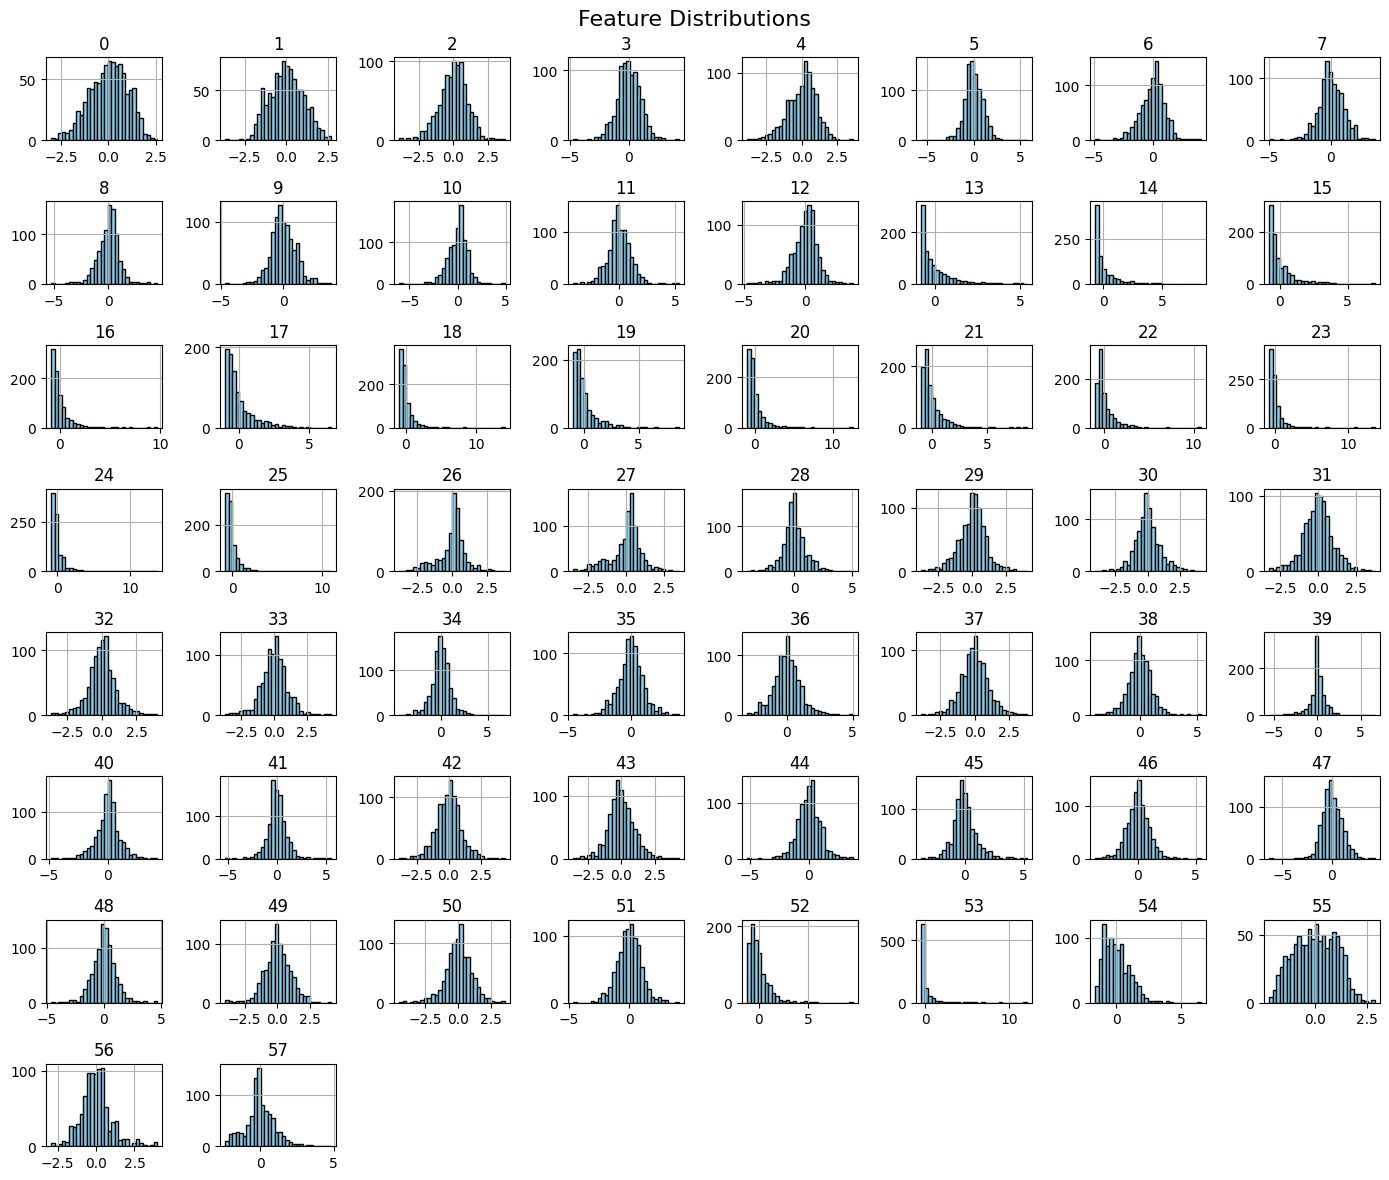

In [14]:
# Get all numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Drop 'label_encoded' only if it exists
if 'label_encoded' in numeric_df.columns:
    numeric_df = numeric_df.drop(columns=['label_encoded'])

# Plot histograms
numeric_df.hist(
    figsize=(14, 12), bins=30, color='skyblue', edgecolor='black'
)
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()


In [15]:
print(df.columns)


Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,         10,         11,
               12,         13,         14,         15,         16,         17,
               18,         19,         20,         21,         22,         23,
               24,         25,         26,         27,         28,         29,
               30,         31,         32,         33,         34,         35,
               36,         37,         38,         39,         40,         41,
               42,         43,         44,         45,         46,         47,
               48,         49,         50,         51,         52,         53,
               54,         55,         56,         57, 'filename', 'category'],
      dtype='object')


4. Dimensionality Reduction

Prepare Data for PCA

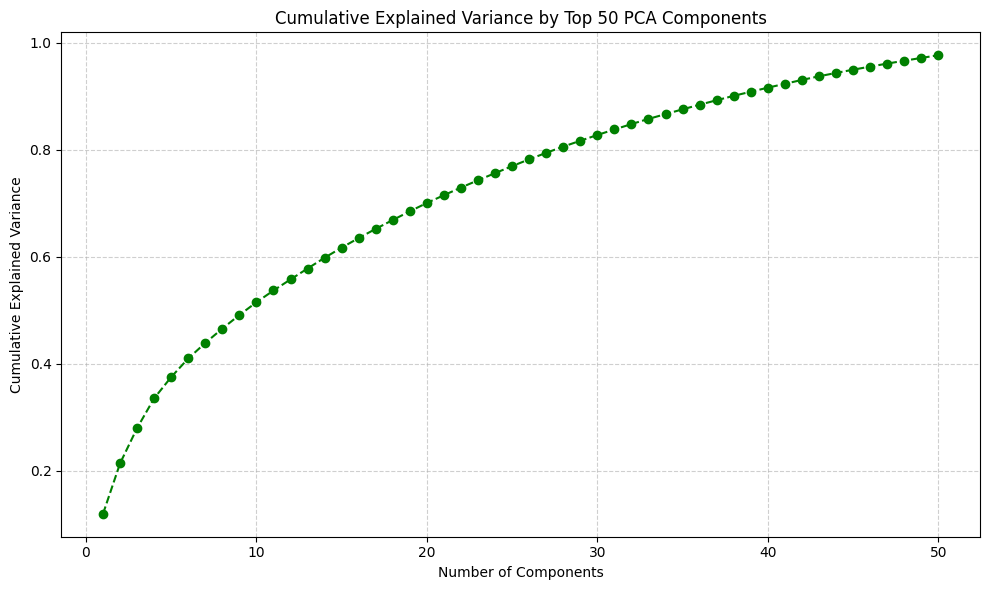

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Drop non-feature columns safely
cols_to_drop = ["filename", "category", "label_encoded"]
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
feature_columns = df.drop(columns=existing_cols_to_drop)

# 2. Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_columns)

# 3. Apply PCA
pca = PCA(n_components=50)
pca_features = pca.fit_transform(scaled_features)

# 4. Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# 5. Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), explained_variance.cumsum(), marker='o', linestyle='--', color='green')
plt.title("Cumulative Explained Variance by Top 50 PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


5. Clustering

Prepare the PCA-reduced feature set

In [49]:
X = pca_features  # Already reduced PCA features

# If 'label_encoded' is missing, re-encode 'category'
from sklearn.preprocessing import LabelEncoder

if 'label_encoded' not in df.columns:
    label_encoder = LabelEncoder()
    y_true = label_encoder.fit_transform(df['category'])
else:
    y_true = df['label_encoded']


K-Means Clustering 

In [52]:
import numpy as np
from sklearn.metrics import pairwise_distances_argmin

def kmeans_from_scratch(X, n_clusters=50, n_iters=100):
    rng = np.random.RandomState(42)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centroids = X[i]

    for _ in range(n_iters):
        labels = pairwise_distances_argmin(X, centroids)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
        
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return labels

kmeans_labels = kmeans_from_scratch(X, n_clusters=50)

In [53]:
# Fix for your DBSCAN code
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=5, min_samples=5)  
dbscan_labels = dbscan.fit_predict(X)
from sklearn.metrics import adjusted_rand_score


if len(y_true) != len(dbscan_labels):
    # Option 1: Trim y_true to match X's length if X is shorter
    if len(X) == len(dbscan_labels):
        y_true = y_true[:len(X)]
    else:
        print(f"Warning: Mismatched lengths - y_true: {len(y_true)}, X: {len(X)}, dbscan_labels: {len(dbscan_labels)}")


In [54]:
from sklearn.metrics import adjusted_rand_score

# Get indices of core/non-noise samples (i.e., labels != -1)
valid_idx = dbscan_labels != -1

# Align y_true and predicted labels
ari_dbscan = adjusted_rand_score(y_true[valid_idx], dbscan_labels[valid_idx])
ari_kmeans = adjusted_rand_score(y_true, kmeans_labels)

print(f"Adjusted Rand Index (KMeans): {ari_kmeans:.4f}")
print(f"Adjusted Rand Index (DBSCAN, excluding noise): {ari_dbscan:.4f}")


Adjusted Rand Index (KMeans): 0.0896
Adjusted Rand Index (DBSCAN, excluding noise): 0.0000


In [43]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score

# DBSCAN from scratch implementation
def dbscan_from_scratch(X, eps=5, min_samples=5):
    """
    DBSCAN implementation from scratch
    
    Parameters:
    X: array-like of shape (n_samples, n_features)
        The input data
    eps: float
        The maximum distance between two samples to be considered neighbors
    min_samples: int
        The minimum number of samples in a neighborhood for a point to be considered a core point
        
    Returns:
    labels: array of shape (n_samples,)
        Cluster labels for each point. Noise points are labeled as -1.
    """
    # Convert X to numpy array if it's a DataFrame
    if hasattr(X, 'values'):
        X = X.values
        
    n_samples = X.shape[0]
    
    # Calculate pairwise distances between all points
    distances = pairwise_distances(X)
    
    # Find neighbors for each point
    neighbors = [np.where(distances[i] <= eps)[0] for i in range(n_samples)]
    
    # Initialize all points as noise
    labels = np.full(n_samples, -1)
    
    # Track which points have been visited
    visited = np.zeros(n_samples, dtype=bool)
    
    # Cluster ID counter
    cluster_id = 0
    
    # Function to expand cluster
    def expand_cluster(point_idx, neighbors_idx, cluster_id):
        # Assign the point to the current cluster
        labels[point_idx] = cluster_id
        
        # Process each neighbor
        i = 0
        while i < len(neighbors_idx):
            neighbor = neighbors_idx[i]
            
            # If not visited, mark as visited
            if not visited[neighbor]:
                visited[neighbor] = True
                
                # Find neighbors of this neighbor
                neighbor_neighbors = neighbors[neighbor]
                
                # If it's a core point, add its neighbors to be processed
                if len(neighbor_neighbors) >= min_samples:
                    neighbors_idx = np.union1d(neighbors_idx, neighbor_neighbors).astype(int)
            
            # If not yet assigned to a cluster, add to current cluster
            if labels[neighbor] == -1:
                labels[neighbor] = cluster_id
                
            i += 1
    
    # Main DBSCAN algorithm
    for i in range(n_samples):
        # Skip if already visited
        if visited[i]:
            continue
            
        # Mark as visited
        visited[i] = True
        
        # Get neighbors
        neighbors_i = neighbors[i]
        
        # If it's a noise point, skip
        if len(neighbors_i) < min_samples:
            continue
            
        # Found a core point, start a new cluster
        expand_cluster(i, neighbors_i, cluster_id)
        cluster_id += 1
    
    return labels

# Main code to run both DBSCAN implementations
def compare_dbscan_implementations(X, y_true, eps=5, min_samples=5):
    # Convert X to numpy array if it's a DataFrame
    if hasattr(X, 'values'):
        X_array = X.values
    else:
        X_array = X
        
    # Convert y_true to numpy array if it's a Series
    if hasattr(y_true, 'values'):
        y_true_array = y_true.values
    else:
        y_true_array = y_true
    
    # Make sure X and y_true have the same length
    if len(X_array) != len(y_true_array):
        print(f"Warning: Mismatched lengths - X: {len(X_array)}, y_true: {len(y_true_array)}")
        y_true_array = y_true_array[:len(X_array)]
        print(f"Trimmed y_true to length: {len(y_true_array)}")
    
    # Run DBSCAN from scratch
    scratch_dbscan_labels = dbscan_from_scratch(X_array, eps=eps, min_samples=min_samples)
    
    # Run scikit-learn DBSCAN
    sklearn_dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    sklearn_dbscan_labels = sklearn_dbscan.fit_predict(X_array)
    
    # For DBSCAN from scratch (excluding noise points)
    valid_idx_scratch = scratch_dbscan_labels != -1
    if np.any(valid_idx_scratch):  # Check if there are any non-noise points
        ari_dbscan_scratch = adjusted_rand_score(
            y_true_array[valid_idx_scratch], 
            scratch_dbscan_labels[valid_idx_scratch]
        )
    else:
        ari_dbscan_scratch = "N/A (all points classified as noise)"
    
    # For scikit-learn DBSCAN (excluding noise points)
    valid_idx_sklearn = sklearn_dbscan_labels != -1
    if np.any(valid_idx_sklearn):  # Check if there are any non-noise points
        ari_dbscan_sklearn = adjusted_rand_score(
            y_true_array[valid_idx_sklearn], 
            sklearn_dbscan_labels[valid_idx_sklearn]
        )
    else:
        ari_dbscan_sklearn = "N/A (all points classified as noise)"
    
    # Print results
    print(f"Adjusted Rand Index (DBSCAN from scratch, excluding noise): {ari_dbscan_scratch}")
    print(f"Adjusted Rand Index (sklearn DBSCAN, excluding noise): {ari_dbscan_sklearn}")
    
    # Print number of clusters found
    n_clusters_scratch = len(np.unique(scratch_dbscan_labels[scratch_dbscan_labels != -1]))
    n_clusters_sklearn = len(np.unique(sklearn_dbscan_labels[sklearn_dbscan_labels != -1]))
    print(f"Number of clusters (DBSCAN from scratch): {n_clusters_scratch}")
    print(f"Number of clusters (sklearn DBSCAN): {n_clusters_sklearn}")
    
    # Print number of noise points
    n_noise_scratch = np.sum(scratch_dbscan_labels == -1)
    n_noise_sklearn = np.sum(sklearn_dbscan_labels == -1)
    print(f"Number of noise points (DBSCAN from scratch): {n_noise_scratch} ({n_noise_scratch/len(X_array)*100:.2f}%)")
    print(f"Number of noise points (sklearn DBSCAN): {n_noise_sklearn} ({n_noise_sklearn/len(X_array)*100:.2f}%)")
    
    return scratch_dbscan_labels, sklearn_dbscan_labels

# Example usage - add this to run the code
if __name__ == "__main__":
    # Convert your data to numpy arrays before using the functions
    X_numpy = X.values if hasattr(X, 'values') else X
    y_true_numpy = y_true.values if hasattr(y_true, 'values') else y_true

    # Call the function with numpy arrays
    scratch_dbscan_labels, sklearn_dbscan_labels = compare_dbscan_implementations(
        X_numpy, y_true_numpy, eps=5, min_samples=5
    )

# If running in a Jupyter notebook, just call the function directly
# scratch_dbscan_labels, sklearn_dbscan_labels = compare_dbscan_implementations(
#     X, y_true, eps=5, min_samples=5
# )

Adjusted Rand Index (DBSCAN from scratch, excluding noise): 0.0017817601069280327
Adjusted Rand Index (sklearn DBSCAN, excluding noise): 0.0
Number of clusters (DBSCAN from scratch): 16
Number of clusters (sklearn DBSCAN): 1
Number of noise points (DBSCAN from scratch): 513 (71.25%)
Number of noise points (sklearn DBSCAN): 473 (65.69%)


.

Hyperparameter Tuning using the validation set

Split into Train and Validation Set
Assuming:

X contains your feature matrix (after PCA or feature selection)
y contains your true labels (i.e., df['label_encoded'])

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Check and encode labels if missing
if 'label_encoded' not in df.columns:
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['category'])

# Now you can safely split
X = df.drop(columns=["filename", "category", "label_encoded"])
y = df["label_encoded"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

best_k = None
best_ari = -1
ari_scores = {}

# Try k values from 30 to 70
for k in range(30, 71, 5):
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(X_val)  # X_val is PCA-reduced validation data
    ari = adjusted_rand_score(y_val, preds)
    ari_scores[k] = ari

    if ari > best_ari:
        best_k = k
        best_ari = ari

print(f"Best K: {best_k}, Best ARI: {best_ari:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Best K: 40, Best ARI: 0.1217


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


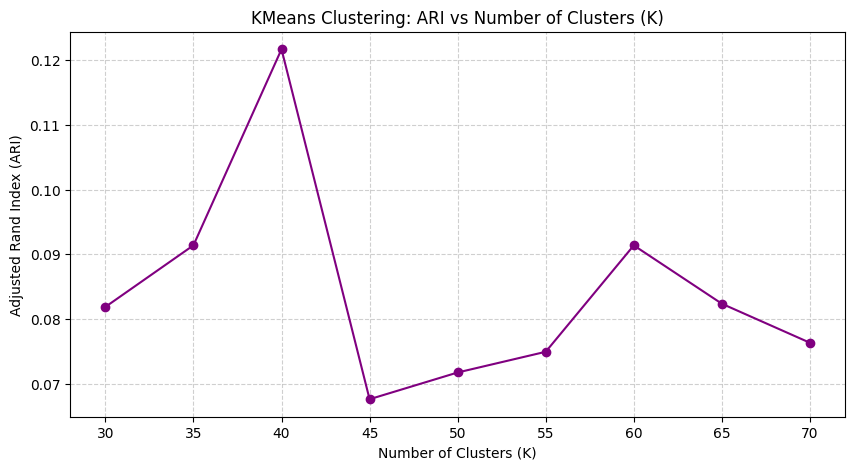

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(list(ari_scores.keys()), list(ari_scores.values()), marker='o', color='purple')
plt.title("KMeans Clustering: ARI vs Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [24]:
from sklearn.cluster import DBSCAN
import numpy as np

eps_values = np.linspace(0.5, 5.0, 10)
min_samples_values = [3, 5, 10]

best_ari = -1
best_params = {}
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        preds = dbscan.fit_predict(X_val)

        # Filter out noise (label -1)
        if len(set(preds)) > 1 and len(set(preds)) < len(X_val):
            ari = adjusted_rand_score(y_val, preds)
            results.append((eps, min_samples, ari))

            if ari > best_ari:
                best_ari = ari
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best DBSCAN params: {best_params}, Best ARI: {best_ari:.4f}")


Best DBSCAN params: {'eps': 5.0, 'min_samples': 5}, Best ARI: 0.0029


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

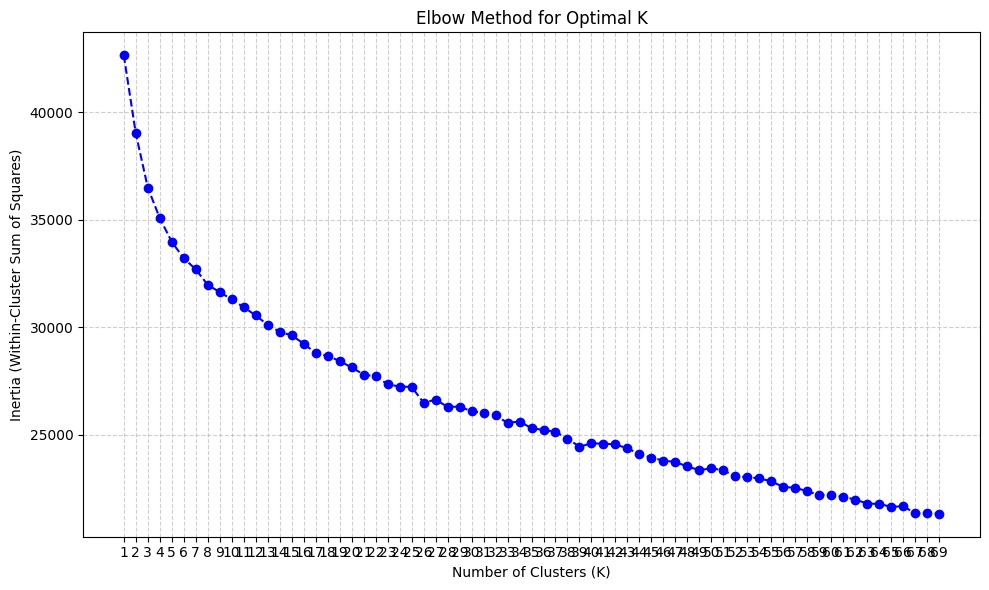

In [57]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# You can use scaled or PCA-reduced features (e.g., X = X_train or X = pca_features)
X = X_train  # or pca_features if you want to apply on PCA-reduced data

inertia_values = []
k_values = range(1, 70)  # Try k from 1 to 20

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o', linestyle='--', color='blue')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(k_values)
plt.tight_layout()
plt.show()
